# Assemble Perturb-seq BMDC data

In [3]:
import scanpy as sc
import pandas as pd
import scipy.io as io

In [4]:
data_path = '/data_volume/memento/bmdc/'

### Process time 0

In [5]:
genes = pd.read_csv(
    data_path + 'raw0/GSM2396857_dc_0hr_genenames.csv', index_col=0)
var_df = pd.DataFrame(index=genes['0'].str.split('_').str[1])
var_df['gene_id'] = genes['0'].str.split('_').str[0].tolist()

cells = pd.read_csv(
    data_path + 'raw0/GSM2396857_dc_0hr_cellnames.csv', index_col=0)
obs_df = pd.DataFrame(index=cells['0'])
obs_df['cell'] = cells['0'].tolist()

mapping = pd.read_csv(data_path + 'raw0/GSM2396857_dc_0hr_cbc_gbc_dict.csv', header=None)
mapping['cell'] = mapping[1].str.split(', ')
mapping = mapping.explode(column='cell').rename(columns={0:'guide'})[['cell', 'guide']]
guides = mapping['guide'].drop_duplicates().tolist()

print(obs_df.shape)
obs_df = obs_df.merge(mapping, on='cell', how='left').astype(str)
obs_df = pd.DataFrame(obs_df.groupby('cell').guide.apply(list))
obs_df['guide_string'] = obs_df['guide'].apply(lambda x: '-'.join(x))
print(obs_df.shape)

# for g in guides:
    
#     obs_df[g] = obs_df['guide'].str.contains(g)

(33063, 1)
(33063, 2)


In [6]:
X = io.mmread(data_path + 'raw0/GSM2396857_dc_0hr.mtx.txt').tocsr()

In [7]:
adata0 = sc.AnnData(X=X.T, obs=obs_df, var=var_df)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1]:
adata0.write(data_path + 'raw0/tp0.h5ad')

NameError: name 'adata0' is not defined

### Process time 3

In [12]:
genes = pd.read_csv(
    data_path + 'raw3/GSM2396856_dc_3hr_genenames.csv', index_col=0)
var_df = pd.DataFrame(index=genes['0'].str.split('_').str[1])
var_df['gene_id'] = genes['0'].str.split('_').str[0].tolist()

cells = pd.read_csv(
    data_path + 'raw3/GSM2396856_dc_3hr_cellnames.csv', index_col=0)
obs_df = pd.DataFrame(index=cells['0'])
obs_df['cell'] = cells['0'].tolist()

mapping = pd.read_csv(data_path + 'raw3/GSM2396856_dc_3hr_cbc_gbc_dict_lenient.csv', header=None)
mapping['cell'] = mapping[1].str.split(', ')
mapping = mapping.explode(column='cell').rename(columns={0:'guide'})[['cell', 'guide']]
guides = mapping['guide'].drop_duplicates().tolist()

print(obs_df.shape)
obs_df = obs_df.merge(mapping, on='cell', how='left').astype(str)
obs_df = pd.DataFrame(obs_df.groupby('cell').guide.apply(list))
obs_df['guide_string'] = obs_df['guide'].apply(lambda x: '-'.join(x))
print(obs_df.shape)

# for g in guides:
    
#     obs_df[g] = obs_df['guide'].str.contains(g)

(32777, 1)
(32777, 2)


In [13]:
X = io.mmread(data_path + 'raw3/GSM2396856_dc_3hr.mtx.txt').tocsr()

In [14]:
adata3 = sc.AnnData(X=X.T, obs=obs_df, var=var_df)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
adata3.write(data_path + 'raw3/tp3.h5ad')

... storing 'guide' as categorical
... storing 'guide_string' as categorical


### Combine

In [16]:
adata0.obs['tp'] = '0hr'
adata3.obs['tp'] = '3hr'

In [17]:
adata0.var_names_make_unique()
adata3.var_names_make_unique()
overlap_genes = adata0.var[[]].copy().join(adata3.var[[]].copy(), how='inner').index.tolist()

In [18]:
adata0 = adata0[:, overlap_genes]
adata3 = adata3[:, overlap_genes]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
adata_combined = adata0.concatenate(adata3)

In [20]:
adata_combined.write(data_path + 'h5ad/bmdc.h5ad')

... storing 'guide' as categorical
... storing 'guide_string' as categorical
... storing 'tp' as categorical


### Preprocess BMDC dataset

In [29]:
(adata.obs.guide_string.apply(lambda x: len(x.split('-'))) == 1)

cell
AAACATACACCAAC_dc0h_G9-0       1
AAACATACACCCTC_dc0h_H9-0       2
AAACATACAGGGTG_dc0h_G9-0       1
AAACATACATCAGC_dc0h_H8-0       2
AAACATACCCATGA_dc0h_G9-0       1
                              ..
TTTGCATGCTTAGG_dc3hLPS_B9-1    1
TTTGCATGCTTAGG_dc3hLPS_C9-1    1
TTTGCATGGGTGGA_dc3hLPS_D8-1    2
TTTGCATGTCGTTT_dc3hLPS_C8-1    2
TTTGCATGTTCGGA_dc3hLPS_B8-1    4
Name: guide_string, Length: 49224, dtype: int64

In [30]:
adata = sc.read(data_path + 'h5ad/bmdc.h5ad')
adata = adata[adata.obs['guide_string']!='nan', :].copy()
adata.obs['WT'] = adata.obs['guide_string'].str.contains('NTC') & (adata.obs.guide_string.apply(lambda x: len(x.split('-'))) == 1)
adata.obs['KO'] = (~adata.obs['guide_string'].str.contains('NTC')).astype(int)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [34]:
# guides = adata.obs.guides.drop_duplicates().tolist()
# guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
# ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

In [35]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [42]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


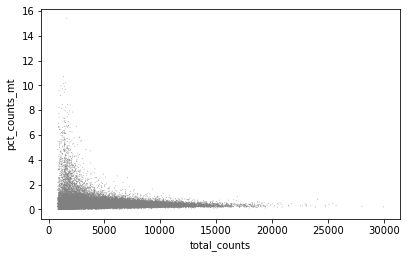

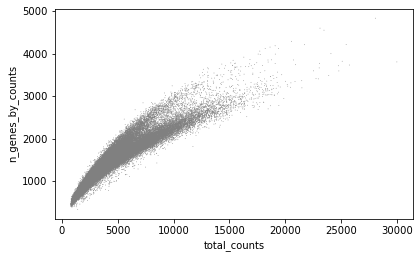

In [44]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [45]:
adata = adata[adata.obs.pct_counts_mt < 2, :]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [46]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [47]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


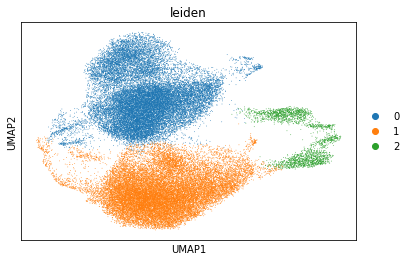

In [48]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color=['leiden'])

In [50]:
# Reconstruct the raw but filtered AnnData object
adata_raw = sc.read(data_path + 'h5ad/bmdc.h5ad')
adata_raw = adata_raw[adata.obs.index, :]
adata_raw.obs = adata.obs.copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [52]:
adata_raw.write(data_path + 'h5ad/filtered-bmdc.h5ad')